# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=7, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=7, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = layers.Conv2D(filters=filters, kernel_size=(7,7), strides=(1,1) ,
                      padding='same', activation='relu')(input_layer)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
        
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 32, 2)
    x2 = encoder_block(x1, 64, 2)
    x3 = encoder_block(x2, 128, 2)
    x4 = encoder_block(x3, 256, 2)
    x5 = encoder_block(x4, 512, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    onebyone_conv_layer = conv2d_batchnorm(x5,1024,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x5_p = decoder_block(onebyone_conv_layer, x4, 512)
    x4_p = decoder_block(x5_p, x3, 256)
    x3_p = decoder_block(x4_p, x2, 128)
    x2_p = decoder_block(x3_p, x1, 64)
    x1_p = decoder_block(x2_p, inputs, 32)
    
    #======Network Shape========
    print(inputs)
    print(x1)
    print(x2)
    print(x3)
    print(x4)
    print(x5)
    print(onebyone_conv_layer)
    print(x5_p)
    print(x4_p)
    print(x3_p)
    print(x2_p)
    print(x1_p)
    #======Network Shape========
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x1_p)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 128, 128, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("batch_normalization_5/batchnorm/add_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 8, 8, 1024), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 16, 16, 512), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("batch_normalization_12/batchnorm/add_1:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("batch_normalization_14/batchnorm/add_1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("batch_normalization_16/batchnorm/add_1:0", s

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.0002
batch_size = 40
num_epochs = 100
num_img_train = 15211#6435
num_img_validation = 1184
steps_per_epoch = int(num_img_train / batch_size) +1
validation_steps = int(num_img_validation / batch_size) +1
workers = 4
print('Steps per epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per epoch: 381
Validation steps: 30


Epoch 1/100
380/381 [============================>.] - ETA: 2s - loss: 0.7144

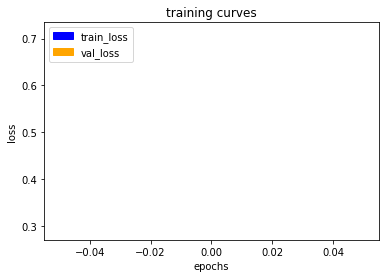

381/381 [==============================] - 1121s - loss: 0.7135 - val_loss: 0.2916
Epoch 2/100
380/381 [============================>.] - ETA: 2s - loss: 0.2515

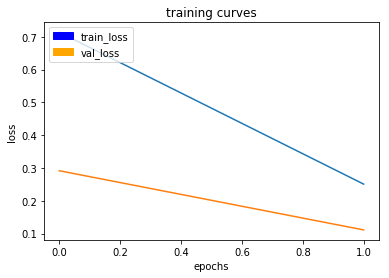

381/381 [==============================] - 1120s - loss: 0.2512 - val_loss: 0.1114
Epoch 3/100
380/381 [============================>.] - ETA: 2s - loss: 0.0986

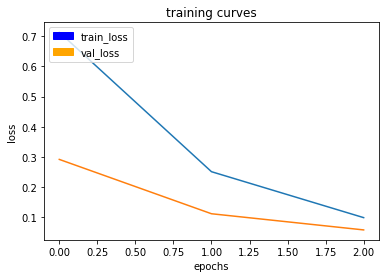

381/381 [==============================] - 1124s - loss: 0.0985 - val_loss: 0.0577
Epoch 4/100
380/381 [============================>.] - ETA: 2s - loss: 0.0563

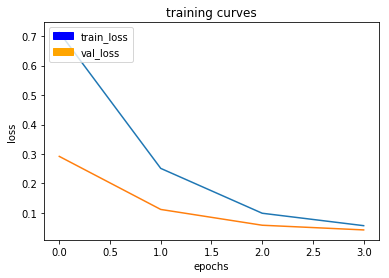

381/381 [==============================] - 1125s - loss: 0.0562 - val_loss: 0.0418
Epoch 5/100
380/381 [============================>.] - ETA: 2s - loss: 0.0439

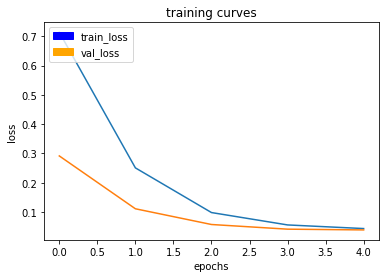

381/381 [==============================] - 1125s - loss: 0.0439 - val_loss: 0.0392
Epoch 6/100
380/381 [============================>.] - ETA: 2s - loss: 0.0345

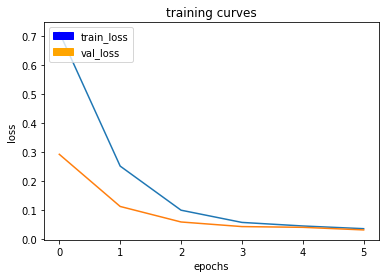

381/381 [==============================] - 1128s - loss: 0.0345 - val_loss: 0.0303
Epoch 7/100
380/381 [============================>.] - ETA: 2s - loss: 0.0287

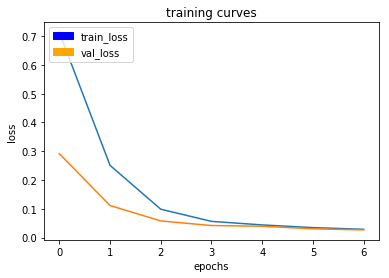

381/381 [==============================] - 1126s - loss: 0.0287 - val_loss: 0.0265
Epoch 8/100
380/381 [============================>.] - ETA: 2s - loss: 0.0364

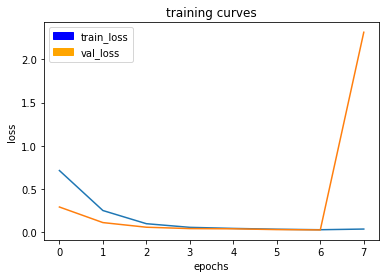

381/381 [==============================] - 1127s - loss: 0.0364 - val_loss: 2.3136
Epoch 9/100
380/381 [============================>.] - ETA: 2s - loss: 0.0343

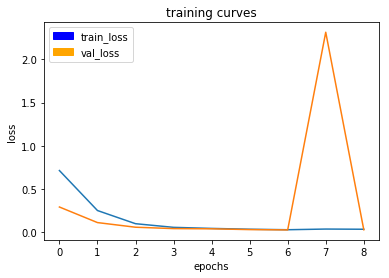

381/381 [==============================] - 1127s - loss: 0.0342 - val_loss: 0.0285
Epoch 10/100
380/381 [============================>.] - ETA: 2s - loss: 0.0252

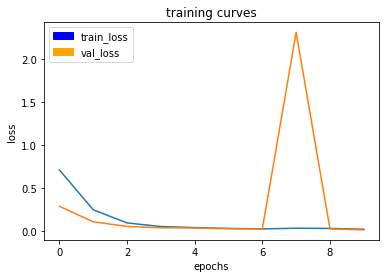

381/381 [==============================] - 1125s - loss: 0.0252 - val_loss: 0.0170
Epoch 11/100
380/381 [============================>.] - ETA: 2s - loss: 0.0253

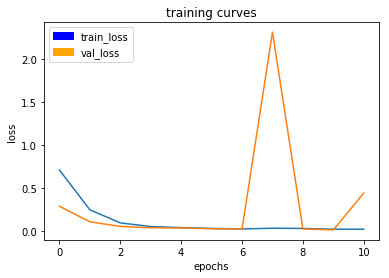

381/381 [==============================] - 1126s - loss: 0.0254 - val_loss: 0.4450
Epoch 12/100
380/381 [============================>.] - ETA: 2s - loss: 0.0256

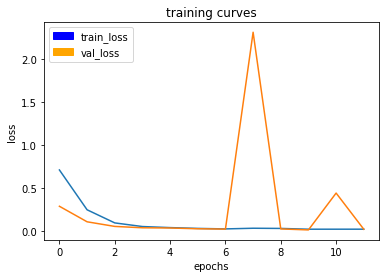

381/381 [==============================] - 1124s - loss: 0.0256 - val_loss: 0.0246
Epoch 13/100
380/381 [============================>.] - ETA: 2s - loss: 0.0207

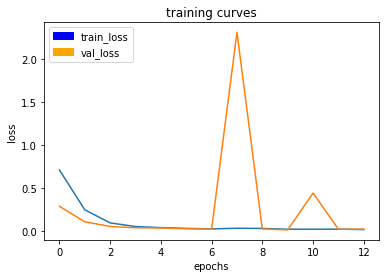

381/381 [==============================] - 1124s - loss: 0.0207 - val_loss: 0.0261
Epoch 14/100
380/381 [============================>.] - ETA: 2s - loss: 0.0194

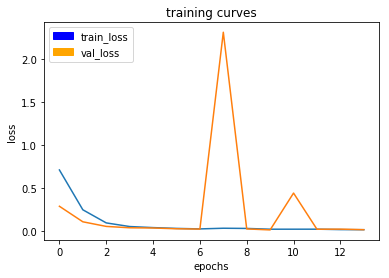

381/381 [==============================] - 1127s - loss: 0.0194 - val_loss: 0.0197
Epoch 15/100
380/381 [============================>.] - ETA: 2s - loss: 0.0197

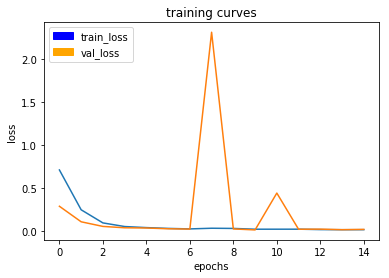

381/381 [==============================] - 1122s - loss: 0.0197 - val_loss: 0.0231
Epoch 16/100
380/381 [============================>.] - ETA: 2s - loss: 0.0178

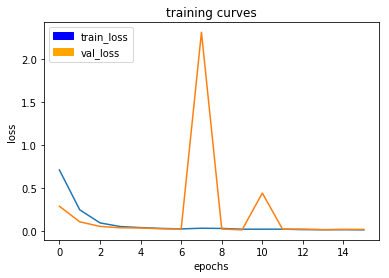

381/381 [==============================] - 1125s - loss: 0.0177 - val_loss: 0.0233
Epoch 17/100
380/381 [============================>.] - ETA: 2s - loss: 0.0204

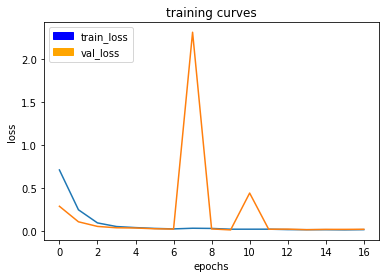

381/381 [==============================] - 1130s - loss: 0.0204 - val_loss: 0.0245
Epoch 18/100
380/381 [============================>.] - ETA: 2s - loss: 0.0175

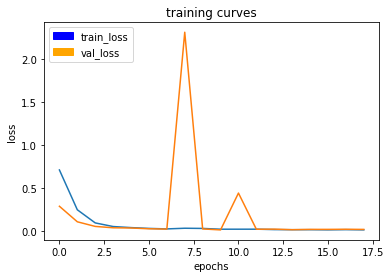

381/381 [==============================] - 1128s - loss: 0.0175 - val_loss: 0.0229
Epoch 19/100
380/381 [============================>.] - ETA: 2s - loss: 0.0160

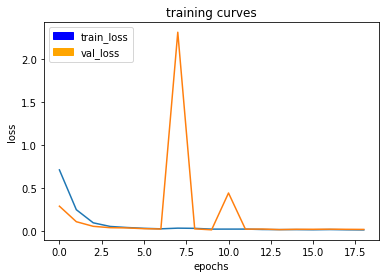

381/381 [==============================] - 1125s - loss: 0.0160 - val_loss: 0.0217
Epoch 20/100
380/381 [============================>.] - ETA: 2s - loss: 0.0168

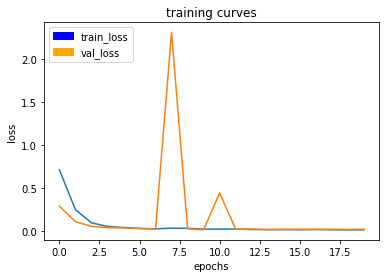

381/381 [==============================] - 1127s - loss: 0.0168 - val_loss: 0.0230
Epoch 21/100
380/381 [============================>.] - ETA: 2s - loss: 0.0183

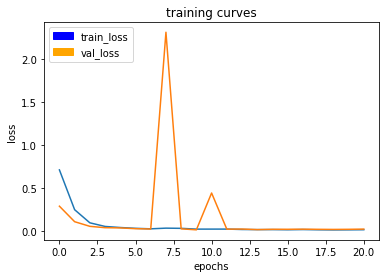

381/381 [==============================] - 1127s - loss: 0.0183 - val_loss: 0.0255
Epoch 22/100
380/381 [============================>.] - ETA: 2s - loss: 0.0181

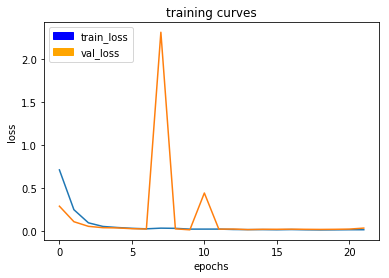

381/381 [==============================] - 1128s - loss: 0.0181 - val_loss: 0.0371
Epoch 23/100
380/381 [============================>.] - ETA: 2s - loss: 0.0158

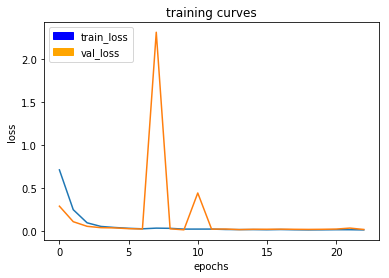

381/381 [==============================] - 1124s - loss: 0.0158 - val_loss: 0.0210
Epoch 24/100
380/381 [============================>.] - ETA: 2s - loss: 0.0164

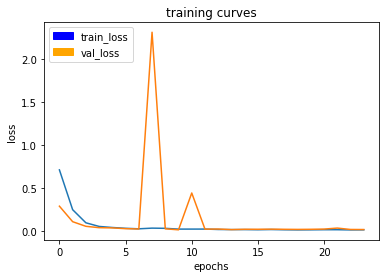

381/381 [==============================] - 1125s - loss: 0.0164 - val_loss: 0.0202
Epoch 25/100
380/381 [============================>.] - ETA: 2s - loss: 0.0143

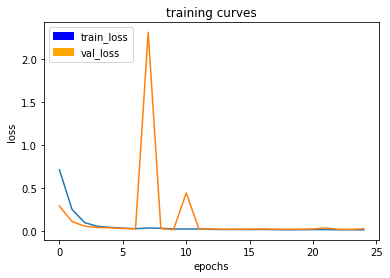

381/381 [==============================] - 1125s - loss: 0.0143 - val_loss: 0.0282
Epoch 26/100
380/381 [============================>.] - ETA: 2s - loss: 0.0138

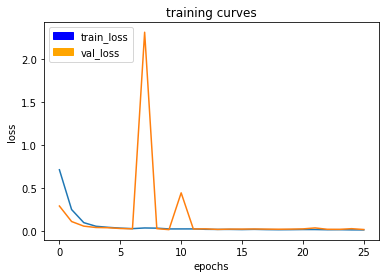

381/381 [==============================] - 1126s - loss: 0.0137 - val_loss: 0.0184
Epoch 27/100
380/381 [============================>.] - ETA: 2s - loss: 0.0138

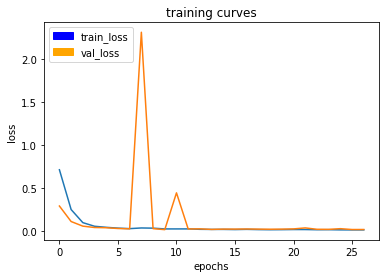

381/381 [==============================] - 1126s - loss: 0.0138 - val_loss: 0.0185
Epoch 28/100
380/381 [============================>.] - ETA: 2s - loss: 0.0136

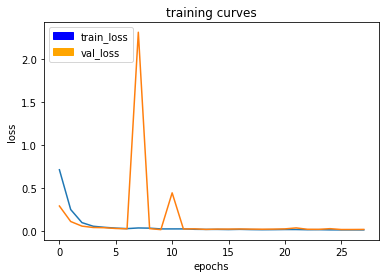

381/381 [==============================] - 1127s - loss: 0.0136 - val_loss: 0.0194
Epoch 29/100
380/381 [============================>.] - ETA: 2s - loss: 0.0129

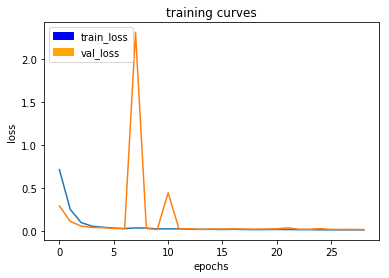

381/381 [==============================] - 1128s - loss: 0.0129 - val_loss: 0.0171
Epoch 30/100
380/381 [============================>.] - ETA: 2s - loss: 0.0134

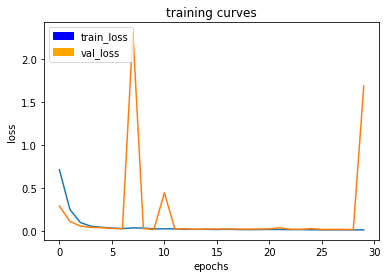

381/381 [==============================] - 1127s - loss: 0.0134 - val_loss: 1.6871
Epoch 31/100
380/381 [============================>.] - ETA: 2s - loss: 0.0156

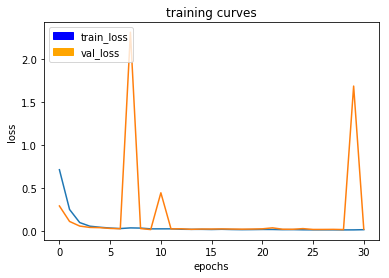

381/381 [==============================] - 1127s - loss: 0.0156 - val_loss: 0.0219
Epoch 32/100
380/381 [============================>.] - ETA: 2s - loss: 0.0137

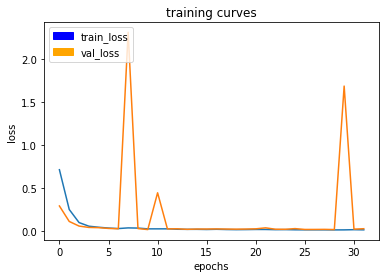

381/381 [==============================] - 1122s - loss: 0.0137 - val_loss: 0.0270
Epoch 33/100
380/381 [============================>.] - ETA: 2s - loss: 0.0135

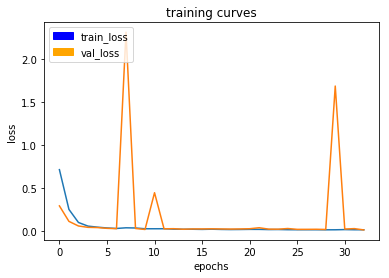

381/381 [==============================] - 1126s - loss: 0.0135 - val_loss: 0.0118
Epoch 34/100
380/381 [============================>.] - ETA: 2s - loss: 0.0122

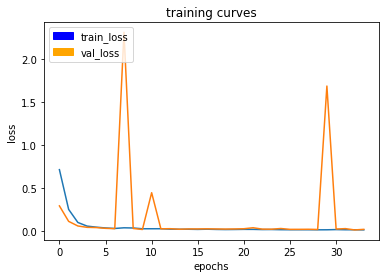

381/381 [==============================] - 1128s - loss: 0.0122 - val_loss: 0.0183
Epoch 35/100
380/381 [============================>.] - ETA: 2s - loss: 0.0117

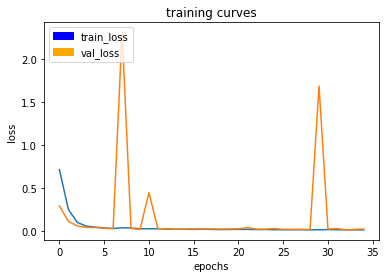

381/381 [==============================] - 1128s - loss: 0.0117 - val_loss: 0.0213
Epoch 36/100
380/381 [============================>.] - ETA: 2s - loss: 0.0113

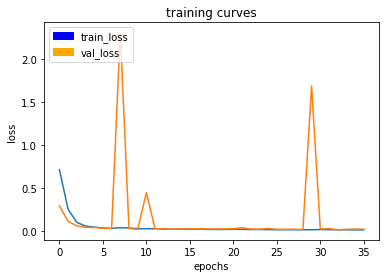

381/381 [==============================] - 1127s - loss: 0.0113 - val_loss: 0.0194
Epoch 37/100
380/381 [============================>.] - ETA: 2s - loss: 0.0112

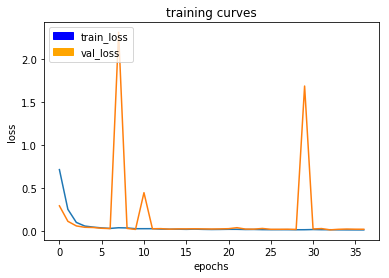

381/381 [==============================] - 1129s - loss: 0.0112 - val_loss: 0.0189
Epoch 38/100
380/381 [============================>.] - ETA: 2s - loss: 0.0109

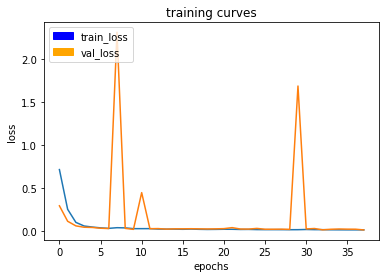

381/381 [==============================] - 1129s - loss: 0.0109 - val_loss: 0.0106
Epoch 39/100
380/381 [============================>.] - ETA: 2s - loss: 0.0106

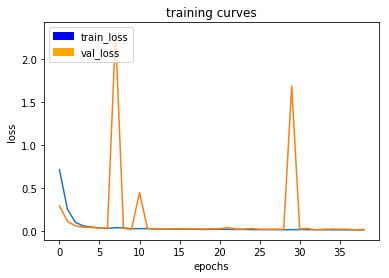

381/381 [==============================] - 1126s - loss: 0.0106 - val_loss: 0.0171
Epoch 40/100
380/381 [============================>.] - ETA: 2s - loss: 0.0107

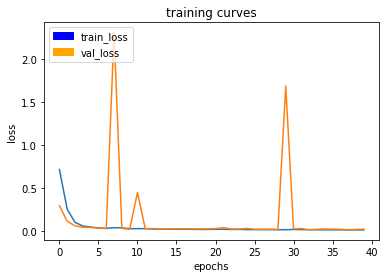

381/381 [==============================] - 1127s - loss: 0.0107 - val_loss: 0.0199
Epoch 41/100
380/381 [============================>.] - ETA: 2s - loss: 0.0159

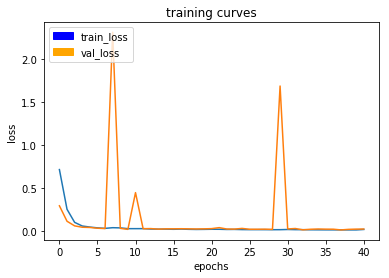

381/381 [==============================] - 1129s - loss: 0.0159 - val_loss: 0.0209
Epoch 42/100
380/381 [============================>.] - ETA: 2s - loss: 0.0118

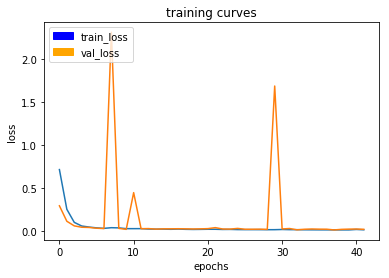

381/381 [==============================] - 1128s - loss: 0.0118 - val_loss: 0.0177
Epoch 43/100
380/381 [============================>.] - ETA: 2s - loss: 0.0109

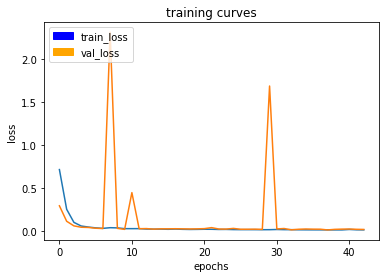

381/381 [==============================] - 1126s - loss: 0.0109 - val_loss: 0.0160
Epoch 44/100
380/381 [============================>.] - ETA: 2s - loss: 0.0104

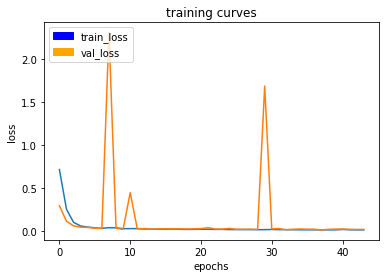

381/381 [==============================] - 1129s - loss: 0.0104 - val_loss: 0.0170
Epoch 45/100
380/381 [============================>.] - ETA: 2s - loss: 0.0101

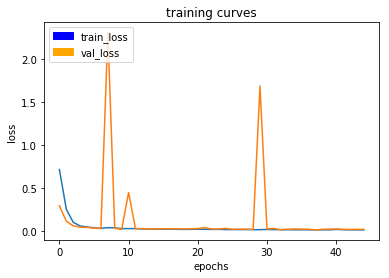

381/381 [==============================] - 1127s - loss: 0.0101 - val_loss: 0.0174
Epoch 46/100
380/381 [============================>.] - ETA: 2s - loss: 0.0098

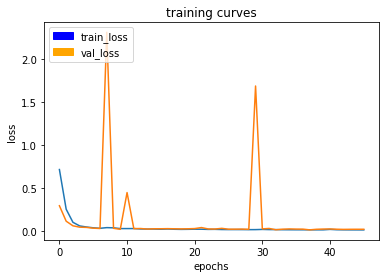

381/381 [==============================] - 1127s - loss: 0.0098 - val_loss: 0.0173
Epoch 47/100
380/381 [============================>.] - ETA: 2s - loss: 0.0099

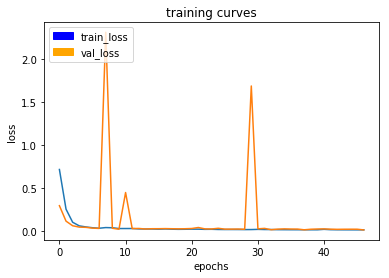

381/381 [==============================] - 1126s - loss: 0.0099 - val_loss: 0.0092
Epoch 48/100
380/381 [============================>.] - ETA: 2s - loss: 0.0097

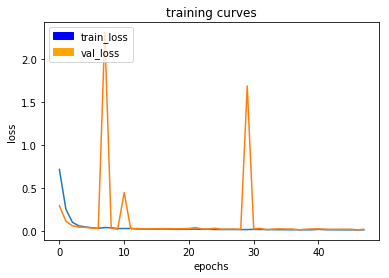

381/381 [==============================] - 1127s - loss: 0.0097 - val_loss: 0.0172
Epoch 49/100
380/381 [============================>.] - ETA: 2s - loss: 0.0094

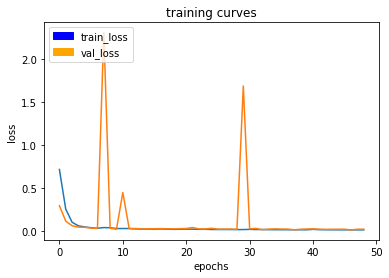

381/381 [==============================] - 1125s - loss: 0.0094 - val_loss: 0.0176
Epoch 50/100
380/381 [============================>.] - ETA: 2s - loss: 0.0094

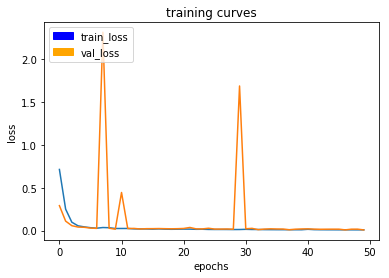

381/381 [==============================] - 1125s - loss: 0.0094 - val_loss: 0.0086
Epoch 51/100
380/381 [============================>.] - ETA: 2s - loss: 0.0092

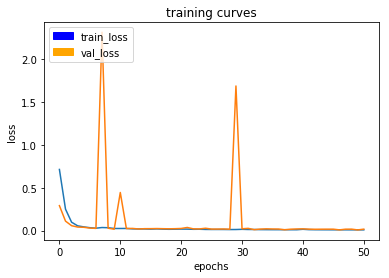

381/381 [==============================] - 1127s - loss: 0.0092 - val_loss: 0.0175
Epoch 52/100
380/381 [============================>.] - ETA: 2s - loss: 0.0128

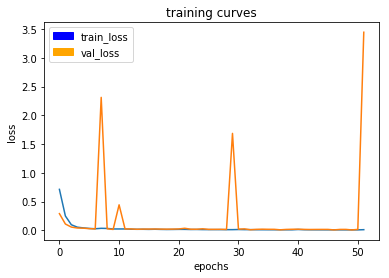

381/381 [==============================] - 1125s - loss: 0.0128 - val_loss: 3.4460
Epoch 53/100
380/381 [============================>.] - ETA: 2s - loss: 0.0129

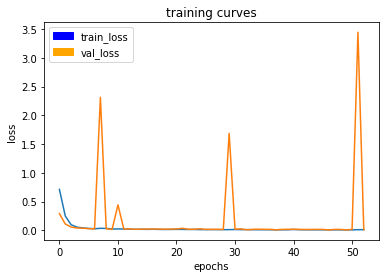

381/381 [==============================] - 1126s - loss: 0.0129 - val_loss: 0.0119
Epoch 54/100
380/381 [============================>.] - ETA: 2s - loss: 0.0100

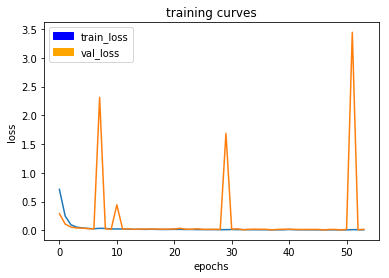

381/381 [==============================] - 1126s - loss: 0.0100 - val_loss: 0.0186
Epoch 55/100
380/381 [============================>.] - ETA: 2s - loss: 0.0094

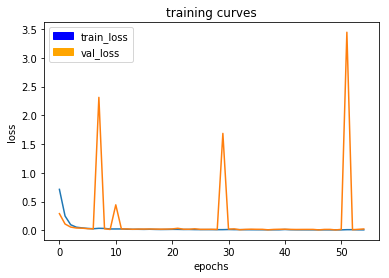

381/381 [==============================] - 1128s - loss: 0.0094 - val_loss: 0.0256
Epoch 56/100
380/381 [============================>.] - ETA: 2s - loss: 0.0092

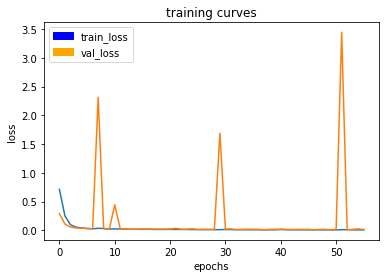

381/381 [==============================] - 1125s - loss: 0.0092 - val_loss: 0.0178
Epoch 57/100
380/381 [============================>.] - ETA: 2s - loss: 0.0089

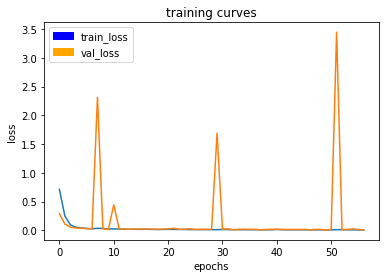

381/381 [==============================] - 1129s - loss: 0.0089 - val_loss: 0.0090
Epoch 58/100
380/381 [============================>.] - ETA: 2s - loss: 0.0088

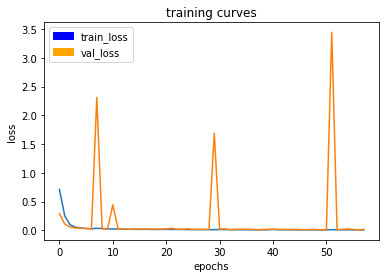

381/381 [==============================] - 1129s - loss: 0.0088 - val_loss: 0.0172
Epoch 59/100
380/381 [============================>.] - ETA: 2s - loss: 0.0088

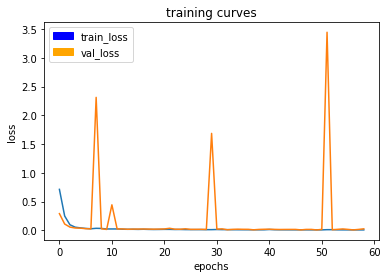

381/381 [==============================] - 1126s - loss: 0.0088 - val_loss: 0.0276
Epoch 60/100
380/381 [============================>.] - ETA: 2s - loss: 0.0086

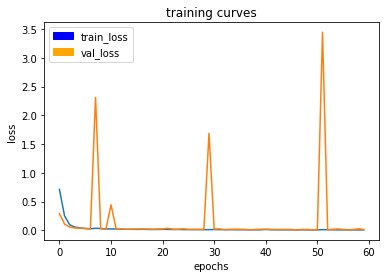

381/381 [==============================] - 1126s - loss: 0.0086 - val_loss: 0.0163
Epoch 61/100
380/381 [============================>.] - ETA: 2s - loss: 0.0085

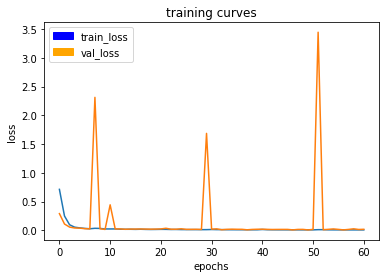

381/381 [==============================] - 1128s - loss: 0.0085 - val_loss: 0.0192
Epoch 62/100
380/381 [============================>.] - ETA: 2s - loss: 0.0085

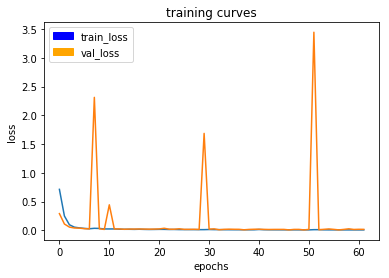

381/381 [==============================] - 1122s - loss: 0.0085 - val_loss: 0.0180
Epoch 63/100
380/381 [============================>.] - ETA: 2s - loss: 0.0084

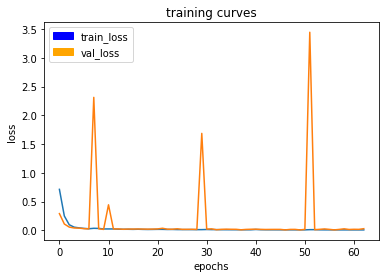

381/381 [==============================] - 1126s - loss: 0.0084 - val_loss: 0.0299
Epoch 64/100
380/381 [============================>.] - ETA: 2s - loss: 0.0084

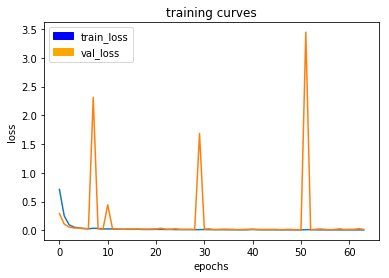

381/381 [==============================] - 1126s - loss: 0.0084 - val_loss: 0.0179
Epoch 65/100
380/381 [============================>.] - ETA: 2s - loss: 0.0083

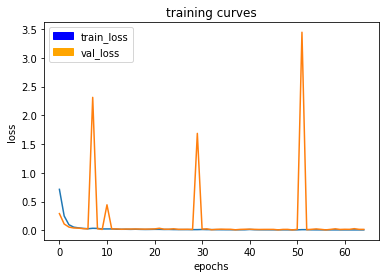

381/381 [==============================] - 1125s - loss: 0.0083 - val_loss: 0.0175
Epoch 66/100
380/381 [============================>.] - ETA: 2s - loss: 0.0082

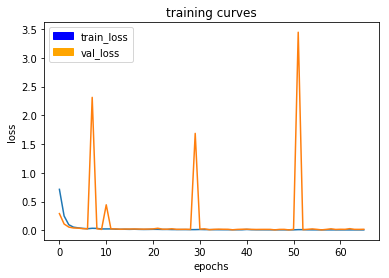

381/381 [==============================] - 1124s - loss: 0.0082 - val_loss: 0.0192
Epoch 67/100
380/381 [============================>.] - ETA: 2s - loss: 0.0080

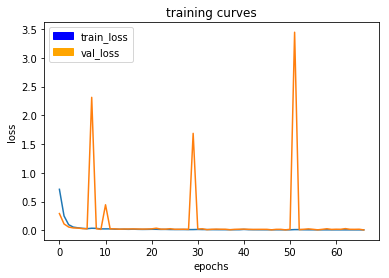

381/381 [==============================] - 1130s - loss: 0.0080 - val_loss: 0.0074
Epoch 68/100
380/381 [============================>.] - ETA: 2s - loss: 0.0079

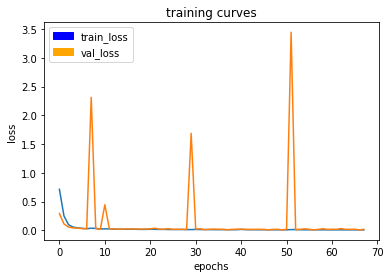

381/381 [==============================] - 1128s - loss: 0.0079 - val_loss: 0.0176
Epoch 69/100
380/381 [============================>.] - ETA: 2s - loss: 0.0082

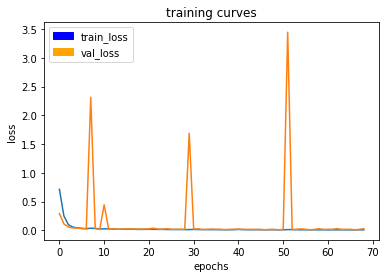

381/381 [==============================] - 1126s - loss: 0.0082 - val_loss: 0.0291
Epoch 70/100
380/381 [============================>.] - ETA: 2s - loss: 0.0131

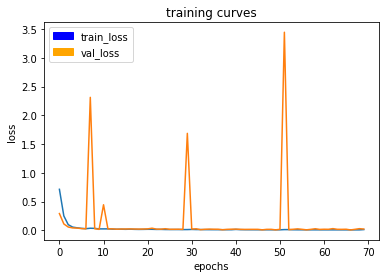

381/381 [==============================] - 1127s - loss: 0.0131 - val_loss: 0.0222
Epoch 71/100
380/381 [============================>.] - ETA: 2s - loss: 0.0095

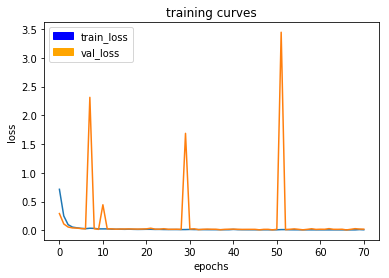

381/381 [==============================] - 1125s - loss: 0.0095 - val_loss: 0.0207
Epoch 72/100
380/381 [============================>.] - ETA: 2s - loss: 0.0087

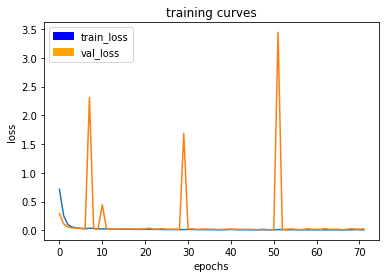

381/381 [==============================] - 1127s - loss: 0.0087 - val_loss: 0.0260
Epoch 73/100
380/381 [============================>.] - ETA: 2s - loss: 0.0082

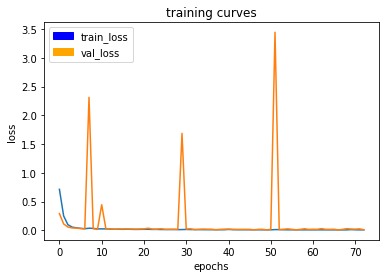

381/381 [==============================] - 1128s - loss: 0.0082 - val_loss: 0.0105
Epoch 74/100
380/381 [============================>.] - ETA: 2s - loss: 0.0079

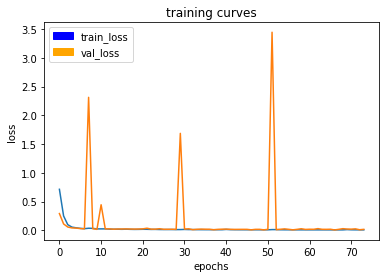

381/381 [==============================] - 1128s - loss: 0.0079 - val_loss: 0.0172
Epoch 75/100
380/381 [============================>.] - ETA: 2s - loss: 0.0077

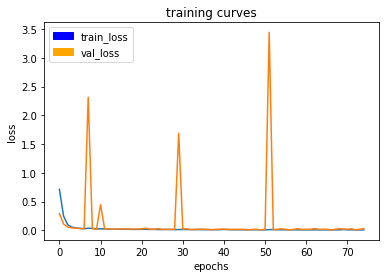

381/381 [==============================] - 1129s - loss: 0.0077 - val_loss: 0.0292
Epoch 76/100
380/381 [============================>.] - ETA: 2s - loss: 0.0077

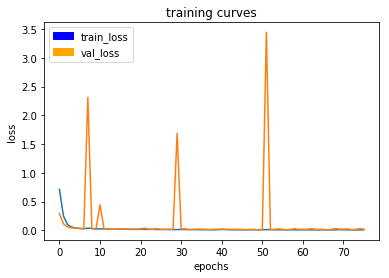

381/381 [==============================] - 1123s - loss: 0.0077 - val_loss: 0.0196
Epoch 77/100
380/381 [============================>.] - ETA: 2s - loss: 0.0076

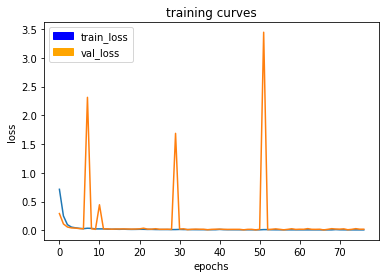

381/381 [==============================] - 1124s - loss: 0.0076 - val_loss: 0.0199
Epoch 78/100
380/381 [============================>.] - ETA: 2s - loss: 0.0076

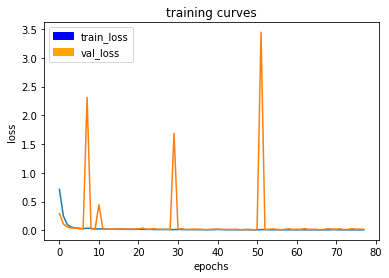

381/381 [==============================] - 1124s - loss: 0.0076 - val_loss: 0.0184
Epoch 79/100
380/381 [============================>.] - ETA: 2s - loss: 0.0075

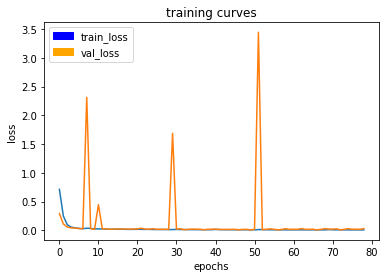

381/381 [==============================] - 1125s - loss: 0.0075 - val_loss: 0.0296
Epoch 80/100
380/381 [============================>.] - ETA: 2s - loss: 0.0074

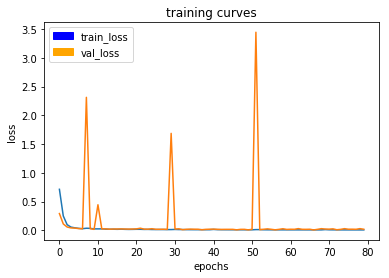

381/381 [==============================] - 1124s - loss: 0.0074 - val_loss: 0.0186
Epoch 81/100
380/381 [============================>.] - ETA: 2s - loss: 0.0074

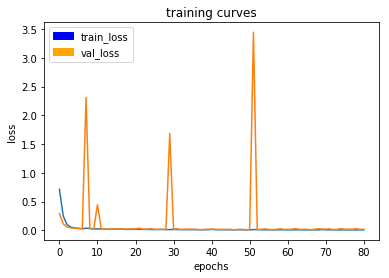

381/381 [==============================] - 1126s - loss: 0.0074 - val_loss: 0.0188
Epoch 82/100
380/381 [============================>.] - ETA: 2s - loss: 0.0074

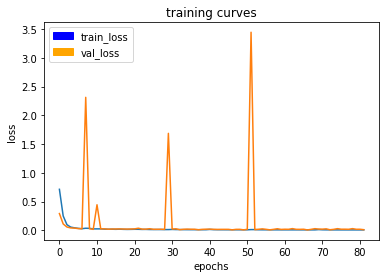

381/381 [==============================] - 1127s - loss: 0.0074 - val_loss: 0.0113
Epoch 83/100
380/381 [============================>.] - ETA: 2s - loss: 0.0073

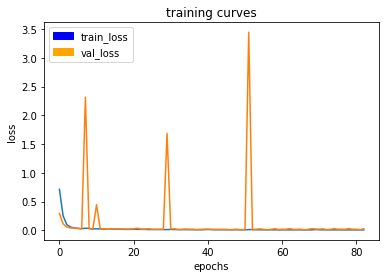

381/381 [==============================] - 1126s - loss: 0.0073 - val_loss: 0.0280
Epoch 84/100
380/381 [============================>.] - ETA: 2s - loss: 0.0100

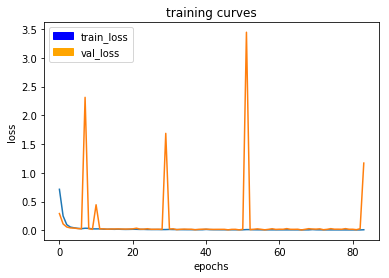

381/381 [==============================] - 1126s - loss: 0.0101 - val_loss: 1.1700
Epoch 85/100
380/381 [============================>.] - ETA: 2s - loss: 0.0124

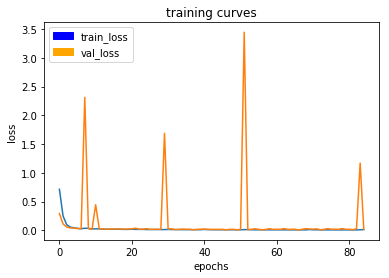

381/381 [==============================] - 1125s - loss: 0.0123 - val_loss: 0.0185
Epoch 86/100
380/381 [============================>.] - ETA: 2s - loss: 0.0094

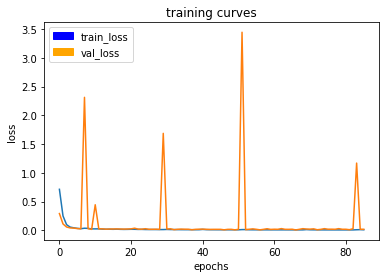

381/381 [==============================] - 1128s - loss: 0.0094 - val_loss: 0.0185
Epoch 87/100
380/381 [============================>.] - ETA: 2s - loss: 0.0084

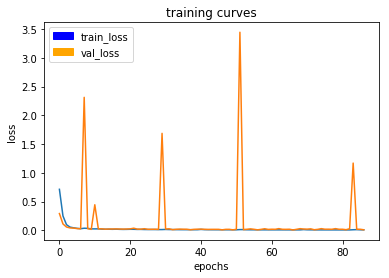

381/381 [==============================] - 1127s - loss: 0.0084 - val_loss: 0.0097
Epoch 88/100
380/381 [============================>.] - ETA: 2s - loss: 0.0098

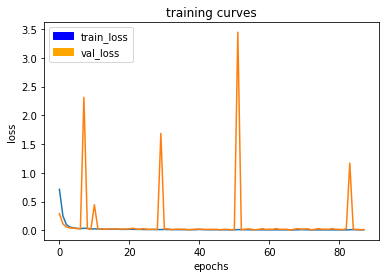

381/381 [==============================] - 1124s - loss: 0.0098 - val_loss: 0.0140
Epoch 89/100
380/381 [============================>.] - ETA: 2s - loss: 0.0094

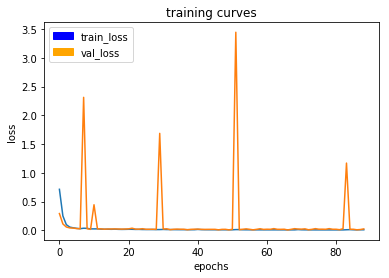

381/381 [==============================] - 1129s - loss: 0.0094 - val_loss: 0.0251
Epoch 90/100
380/381 [============================>.] - ETA: 2s - loss: 0.0085

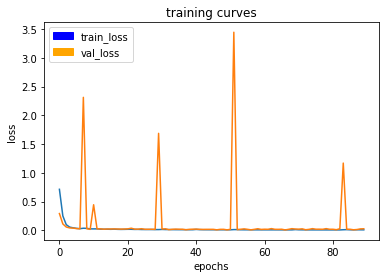

381/381 [==============================] - 1130s - loss: 0.0085 - val_loss: 0.0274
Epoch 91/100
380/381 [============================>.] - ETA: 2s - loss: 0.0078

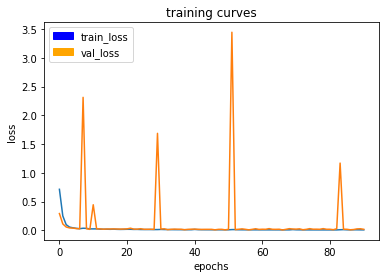

381/381 [==============================] - 1123s - loss: 0.0078 - val_loss: 0.0175
Epoch 92/100
380/381 [============================>.] - ETA: 2s - loss: 0.0075

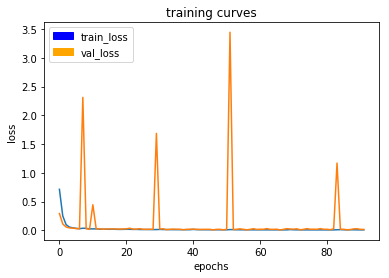

381/381 [==============================] - 1129s - loss: 0.0075 - val_loss: 0.0157
Epoch 93/100
380/381 [============================>.] - ETA: 2s - loss: 0.0074

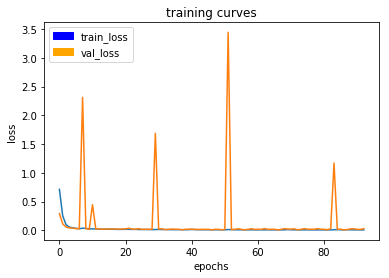

381/381 [==============================] - 1127s - loss: 0.0074 - val_loss: 0.0297
Epoch 94/100
380/381 [============================>.] - ETA: 2s - loss: 0.0073

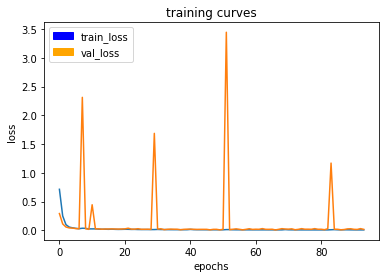

381/381 [==============================] - 1127s - loss: 0.0073 - val_loss: 0.0164
Epoch 95/100
380/381 [============================>.] - ETA: 2s - loss: 0.0072

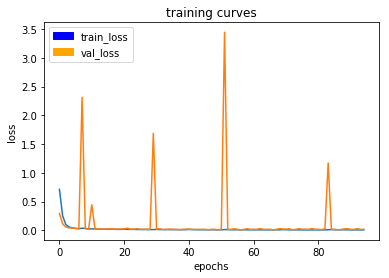

381/381 [==============================] - 1127s - loss: 0.0072 - val_loss: 0.0193
Epoch 96/100
380/381 [============================>.] - ETA: 2s - loss: 0.0071

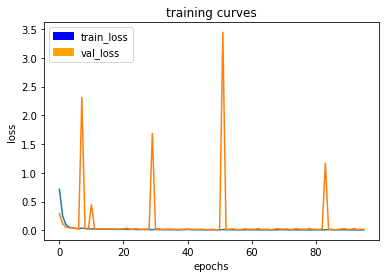

381/381 [==============================] - 1126s - loss: 0.0071 - val_loss: 0.0191
Epoch 97/100
380/381 [============================>.] - ETA: 2s - loss: 0.0071

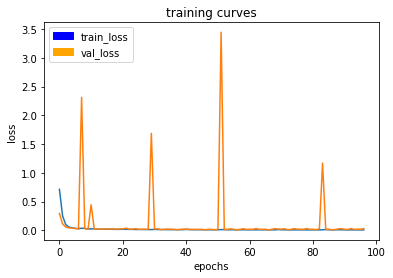

381/381 [==============================] - 1129s - loss: 0.0071 - val_loss: 0.0294
Epoch 98/100
380/381 [============================>.] - ETA: 2s - loss: 0.0070

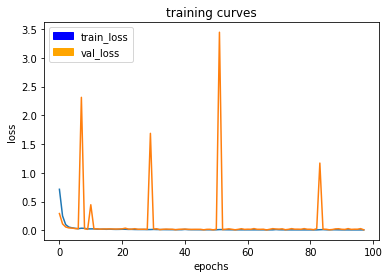

381/381 [==============================] - 1126s - loss: 0.0070 - val_loss: 0.0088
Epoch 99/100
380/381 [============================>.] - ETA: 2s - loss: 0.0070

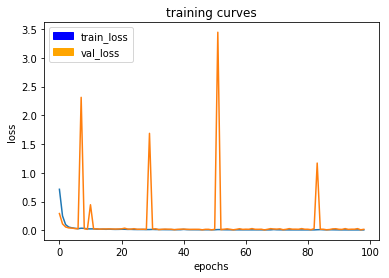

381/381 [==============================] - 1125s - loss: 0.0070 - val_loss: 0.0174
Epoch 100/100
380/381 [============================>.] - ETA: 2s - loss: 0.0069

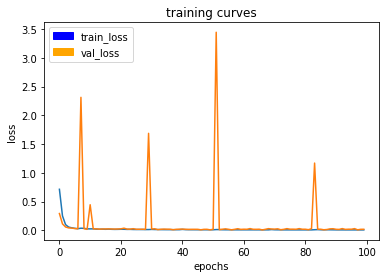

381/381 [==============================] - 1126s - loss: 0.0069 - val_loss: 0.0179


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.compile(optimizer=keras.optimizers.Nadam(lr=learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

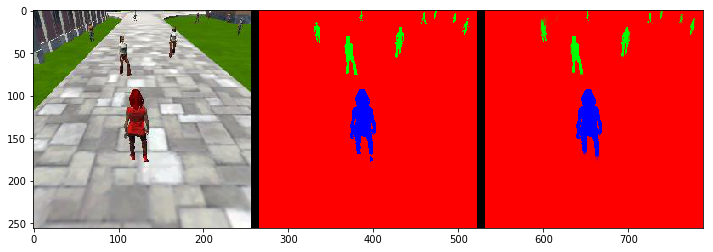

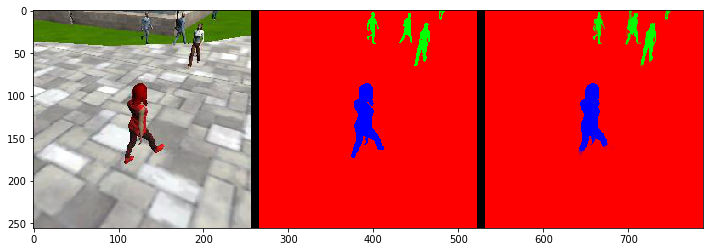

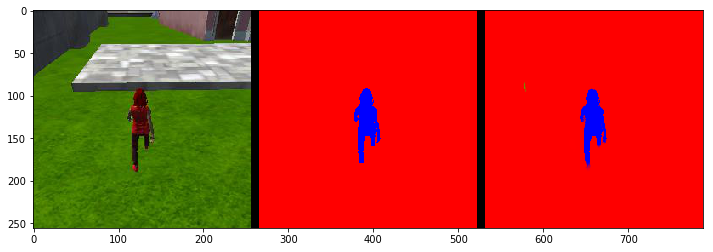

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

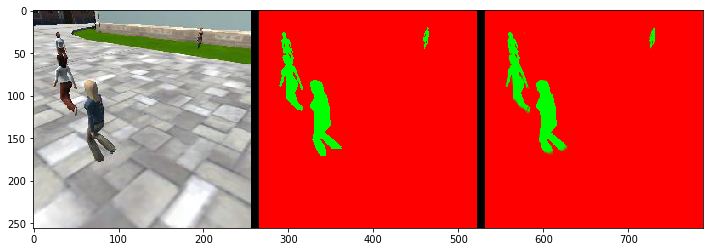

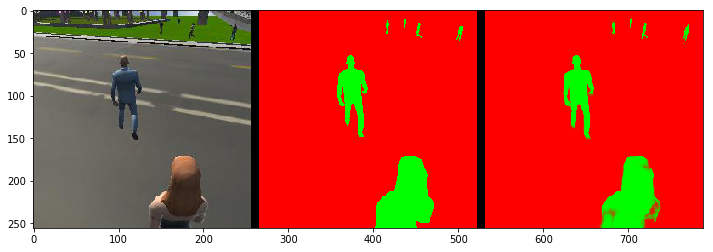

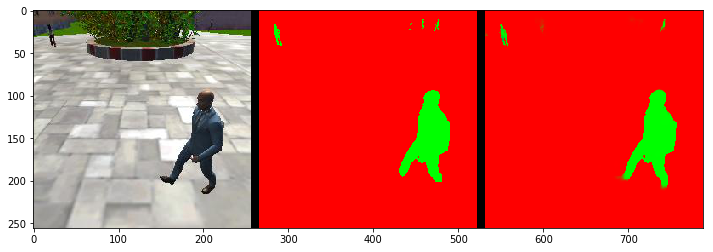

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

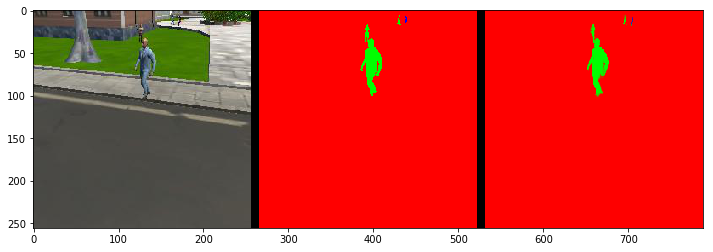

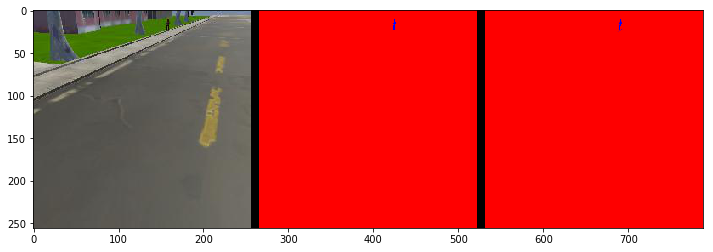

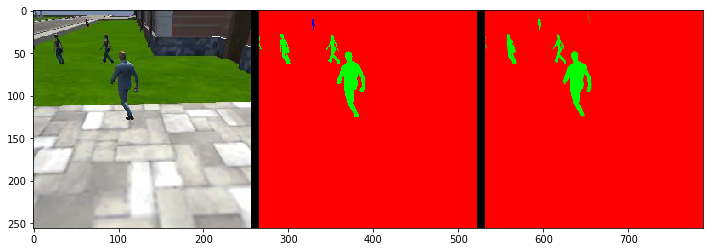

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9983695881733685
average intersection over union for other people is 0.539805880326334
average intersection over union for the hero is 0.963038676520377
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9958944904693255
average intersection over union for other people is 0.9202478636074581
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 11, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9987046643382497
average intersection over union for other people is 0.659032338204736
average intersection over union for the hero is 0.5121979089588117
number true positives: 201, number false positives: 1, number false negatives: 111


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.8574739281575898


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.73761829274


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.632488454956
